In [ ]:
import numpy as np
from numba import jit

np.set_printoptions(suppress=True)

def ordenamiento_burbuja(arreglo):
  for pos_final in range(len(arreglo), 1, -1):
    for i in range(pos_final - 1):
      if arreglo[i] > arreglo[i + 1]:
        tmp = arreglo[i]
        arreglo[i] = arreglo[i + 1]
        arreglo[i + 1] = tmp

#este jit no paraleliza, solo optimiza el cpu para compilar en just in time.
@jit
def ordenamiento_burbuja_numba(arreglo):
  for pos_final in range(len(arreglo), 1, -1):
    for i in range(pos_final - 1):
      if arreglo[i] > arreglo[i + 1]:
        tmp = arreglo[i]
        arreglo[i] = arreglo[i + 1]
        arreglo[i + 1] = tmp

The %timeit magic command is typically used in Jupyter Notebook or IPython to measure the execution time of a particular code snippet.

- -r 10: It specifies that the code should be executed 10 times to get more accurate timing results.
- -n 30: It sets the number of loops for each timing measurement to 30. This means that each timing measurement is the average of 30 executions.

In [ ]:
%timeit -r 10 -n 30 arreglo1 = np.random.rand(1000); ordenamiento_burbuja(arreglo1)
%timeit -r 10 -n 30 arreglo2 = np.random.rand(1000); ordenamiento_burbuja_numba(arreglo2)
%timeit -r 10 -n 30 arreglo3 = np.random.rand(1000); arreglo3.sort()

200 ms ± 22.2 ms per loop (mean ± std. dev. of 10 runs, 30 loops each)
The slowest run took 10.19 times longer than the fastest. This could mean that an intermediate result is being cached.
2.38 ms ± 3.36 ms per loop (mean ± std. dev. of 10 runs, 30 loops each)
57.1 µs ± 20.9 µs per loop (mean ± std. dev. of 10 runs, 30 loops each)


In [ ]:
# Commented out IPython magic to ensure Python compatibility.
from numba import vectorize, float64
import numpy as np 

#Este vectorize sí es de numba, el primer valor es lo que regresa y entre paréntesis lo que le das.
@vectorize([float64(float64, float64)])
def suma_numba(a, b):
  return a + b

#Esta es la suma de listas normal y serial.
def suma_listas(a, b):
  c = []
  for i in range(len(a)):
    c.append(a[i] + b[i])
  return c
#Esta solo suma arreglos de numpy
def suma_numpy(a, b):
  return a + b

In [ ]:
arreglo1 = np.random.rand(10000)
arreglo2 = np.random.rand(10000)
lista1 = list(arreglo1)
lista2 = list(arreglo2)

%timeit -r 10 -n 3000 suma_numba(arreglo1, arreglo2)
%timeit -r 10 -n 3000 suma_numba(lista1, lista2)
%timeit -r 10 -n 3000 suma_listas(lista1, lista2)
%timeit -r 10 -n 3000 suma_numpy(arreglo1, arreglo2)

3.99 µs ± 135 ns per loop (mean ± std. dev. of 10 runs, 3000 loops each)
949 µs ± 123 µs per loop (mean ± std. dev. of 10 runs, 3000 loops each)
1.29 ms ± 188 µs per loop (mean ± std. dev. of 10 runs, 3000 loops each)
4.2 µs ± 124 ns per loop (mean ± std. dev. of 10 runs, 3000 loops each)


numba_y_cuda_para_gpus

In [ ]:
import numpy as np
from numba import cuda

In [ ]:
print(cuda.gpus)
print(cuda.detect())
#Aquí estás seleccionando el primer device de CUDA, por si tuvieras más de uno.

cuda.select_device(0)

<Managed Device 0>
Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-501b63ef-42a5-a642-090b-2f76f135193c
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
True


<weakproxy at 0x7f832c11a430 to Device at 0x7f832c51b4c0>

In [ ]:
#Aquí sólo son las especificaciones de las versiones de CUDA, el value es cuántos SM tiene.
cc_cores_per_SM_dict = {(2,0) : 32, 
                        (2,1) : 48, 
                        (3,0) : 192, 
                        (3,5) : 192, 
                        (3,7) : 192, 
                        (5,0) : 128, 
                        (5,2) : 128, 
                        (6,0) : 64, 
                        (6,1) : 128, 
                        (7,0) : 64, 
                        (7,5) : 64, 
                        (8,0) : 64, 
                        (8,6) : 128, 
                        (8,9) : 128, 
                        (9,0) : 128 }

GPU compute capability: (7, 5) indica que la GPU tiene una capacidad de cálculo de versión 7.5. Esto implica que la GPU es compatible con características y funciones específicas asociadas con esa versión de la arquitectura.

In [ ]:
#Especificaciones por device
device = cuda.get_current_device()
sms = getattr(device, "MULTIPROCESSOR_COUNT")
#Obtiene la capacidad de cálculo del gpu actual
cc = device.compute_capability
#Aquí usamos las capacidades de cálculo para obtener el número de SM
cores_por_sm = cc_cores_per_SM_dict.get(cc)
#Aquí multiplicamos el numero de cores por sm por el número de sms.
cores_totales = cores_por_sm * sms
print("GPU compute capability: ", cc)
print("Número de SM: ", sms)
print("Número de cores: ", cores_totales)

GPU compute capability:  (7, 5)
Número de SM:  40
Número de cores:  2560


dir(enum) se utiliza para obtener una lista de todos los nombres definidos en un módulo o en un objeto

In [ ]:
from numba.cuda.cudadrv import enums
from numba import cuda

#Aquí solo imprimimos TOOODOS los attributes posibles para el device que estamos utilizando.
device = cuda.get_current_device()
attribs = [name.replace("CU_DEVICE_ATTRIBUTE_", "") for name in dir(enums) if name.startswith("CU_DEVICE_ATTRIBUTE_")]
for attr in attribs:
    print(attr, "=", getattr(device, attr))

ASYNC_ENGINE_COUNT = 3
CAN_MAP_HOST_MEMORY = 1
CAN_USE_HOST_POINTER_FOR_REGISTERED_MEM = 1
CLOCK_RATE = 1590000
COMPUTE_CAPABILITY_MAJOR = 7
COMPUTE_CAPABILITY_MINOR = 5
COMPUTE_MODE = 0
COMPUTE_PREEMPTION_SUPPORTED = 1
CONCURRENT_KERNELS = 1
CONCURRENT_MANAGED_ACCESS = 1
COOPERATIVE_LAUNCH = 1
COOPERATIVE_MULTI_DEVICE_LAUNCH = 1
ECC_ENABLED = 1
GLOBAL_L1_CACHE_SUPPORTED = 1
GLOBAL_MEMORY_BUS_WIDTH = 256
GPU_OVERLAP = 1
HOST_NATIVE_ATOMIC_SUPPORTED = 0
INTEGRATED = 0
IS_MULTI_GPU_BOARD = 0
KERNEL_EXEC_TIMEOUT = 0
L2_CACHE_SIZE = 4194304
LOCAL_L1_CACHE_SUPPORTED = 1
MANAGED_MEMORY = 1
MAX_BLOCK_DIM_X = 1024
MAX_BLOCK_DIM_Y = 1024
MAX_BLOCK_DIM_Z = 64
MAX_GRID_DIM_X = 2147483647
MAX_GRID_DIM_Y = 65535
MAX_GRID_DIM_Z = 65535
MAX_MAX_TEXTURE_2D_MIPMAPPED_HEIGHT = 32768
MAX_PITCH = 2147483647
MAX_REGISTERS_PER_BLOCK = 65536
MAX_REGISTERS_PER_MULTIPROCESSOR = 65536
MAX_SHARED_MEMORY_PER_BLOCK = 49152
MAX_SHARED_MEMORY_PER_BLOCK_OPTIN = 65536
MAX_SHARED_MEMORY_PER_MULTIPROCESSOR = 65536
MAX_S

Definiendo y lanzando un kernel

In [ ]:
#Ejemplo más básico de kernel (no hace nada).
@cuda.jit
def un_kernel(x, y, out):
  """ Este es un kernel de dos variables de entrada "x" e "y"
  y una variable de salida out """
  pass

In [ ]:
#Aquí solo estamos viendo que podemos crear matrices del mismo tamaño, definir matrices "vacías" y mandar al kernel con parámetros.
x = np.ones(256)
y = x * 2
out = np.empty_like(x)
threads_per_block = 32
num_blocks = 10
#Aquí es importante ver que SIEMPREE es algo como kernel[num_blocks, threads per block](parametros de tu kernel)
un_kernel[num_blocks, threads_per_block](x, y, out)
#Aquí lo que está pasando con el out es que te da lo que estaba almacenado previamente en ese espacio de memoria.
print(out)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[6.92408710e-310 6.92408710e-310 2.72149381e-316 2.72149381e-316
 1.05118732e-153 1.03118977e-071 7.11326537e-067 1.30388877e-076
 2.95258381e+179 1.69765945e-139 9.76515891e+199 4.10521058e+223
 8.94213159e+130 4.47191900e-033 1.65618618e-076 1.30388877e-076
 3.43506111e+179 6.01353866e-154 9.35154065e-067 1.19982116e+141
 1.10670705e-320 1.39919391e-320 0.00000000e+000 4.85574041e-317
 1.36707964e-320             nan 6.80085839e+199 0.00000000e+000
 1.50008929e+248 4.31174539e-096 1.15998412e-028 6.80275364e+199
 3.07957399e+203 1.39029197e-142 7.69152992e+218 1.23762599e+224
 1.04918335e-153 1.30435492e+214 4.52341208e+257 2.18174653e+243
 1.62691054e+219 1.23764895e+224 9.32219588e+218 3.55455412e+180
 2.49310696e+184 4.49851566e+174 3.27597791e+222 2.51313104e+180
 5.29862106e+180 5.50013462e-143 5.36835912e+252 1.91611764e+214
 5.49012399e-143 1.05996186e-153 5.82659549e+252 4.52341208e+257
 9.47752035e+170 1.16145749e-028 8.33236358e+151 6.98864973e+228
 1.05894445e-153 1.432735

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Kernel doblador - debugger

In [ ]:
#Aquí ya sabemos que hay que iniciar con cuda.jit
@cuda.jit
#este kernel duplica todo lo que hay en el arreglo (mientras que la posición del hilo sea más pequeña que el tamaño del arreglo)
def kernel_doblador(arreglo, log):
  thread_id = cuda.threadIdx.x
  block_id = cuda.blockIdx.x
  # En estos 2 renglones lo que hacemos es sacar cuantos hilos hay por bloque y  asigna la posición en la que se encuentra cada hilo.
  threads_per_block = cuda.blockDim.x 
  position = thread_id + block_id * threads_per_block    
  if position < arreglo.size:
    arreglo[position] *= 2
    log[position][0] = position
    log[position][1] = thread_id
    log[position][2] = block_id
    log[position][3] = threads_per_block

In [11]:
x = np.ones(256)
log = np.zeros(shape=(x.size, 4))
threads_per_block = 32 * 3
num_blocks = 2
kernel_doblador[num_blocks, threads_per_block](x, log)
print(x)
for registro in log:
  print(registro)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 0.  0.  0. 96.]
[ 1.  1.  0. 96.]
[ 2.  2.  0. 96.]
[ 3.  3.  0. 96.]
[ 4.  4.  0. 96.]
[ 5.  5.  0. 96.]
[ 6.  6.  0. 96.]
[ 7.  7.  0. 96.]
[ 8.  8.  0. 96.]
[ 9.  9.  0. 96.]
[10. 10.  0. 96.]
[11. 11.  0. 96.]
[12.

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Kernel con despliegue adaptable a datos

In [12]:
import math
import numpy as np
from numba import cuda

@cuda.jit
def kernel_sumador(x, y, out):
  #thread_id = cuda.threadIdx.x
  #block_id = cuda.blockIdx.x
  #threads_per_block = cuda.blockDim.x
  #num_blocks = cuda.gridDim.x
  #start = thread_id + block_id * threads_per_block

  #Se puede usar directamente cuda.grid
  start = cuda.grid(1)  
  #step = threads_per_block * num_blocks

  #Se puede usar directamente cuda.gridsize (el step se utiliza cuando estamos teniendo más operaciones que hilos y se las reparten)
  step = cuda.gridsize(1)
  #Aquí ya nada más sumamos.
  for i in range(start, x.size, step):
    out[i] = x[i] + y[i]

In [14]:
x = np.arange(500)
y = x * 2
out = np.empty_like(x)
threads_per_block = 32

#Aquí sólo estamos dividiendo la cantidad de x entre el número de threads.
num_blocks = int(math.ceil(x.size / threads_per_block))
print(num_blocks)
kernel_sumador[num_blocks, threads_per_block](x, y, out)

16


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [15]:
print(out)

[   0    3    6    9   12   15   18   21   24   27   30   33   36   39
   42   45   48   51   54   57   60   63   66   69   72   75   78   81
   84   87   90   93   96   99  102  105  108  111  114  117  120  123
  126  129  132  135  138  141  144  147  150  153  156  159  162  165
  168  171  174  177  180  183  186  189  192  195  198  201  204  207
  210  213  216  219  222  225  228  231  234  237  240  243  246  249
  252  255  258  261  264  267  270  273  276  279  282  285  288  291
  294  297  300  303  306  309  312  315  318  321  324  327  330  333
  336  339  342  345  348  351  354  357  360  363  366  369  372  375
  378  381  384  387  390  393  396  399  402  405  408  411  414  417
  420  423  426  429  432  435  438  441  444  447  450  453  456  459
  462  465  468  471  474  477  480  483  486  489  492  495  498  501
  504  507  510  513  516  519  522  525  528  531  534  537  540  543
  546  549  552  555  558  561  564  567  570  573  576  579  582  585
  588 

Kernel sumador PT2

In [17]:
x_host = np.arange(500)
y_host = x_host * 2
out_host = np.empty_like(x_host)

#Aquí lo que estamos haciendo es transferir nuestras estructuras de datos a la memoria del gpu (no es compartida)
x_device = cuda.to_device(x_host)
y_device = cuda.to_device(y_host)
out_device = cuda.device_array_like(x_host)

threads_per_block = 32
#Una vez más, aquí sólo dividimos el trabajo.
num_blocks = int(math.ceil(x.size / threads_per_block))
#Aquí ahora sí ejecutamos dentro del gpu (usamos las variables correctas).
kernel_sumador[num_blocks, threads_per_block](x_device, 
                                               y_device,
                                               out_device)

#No se te olvide que hay que sacar la información del device al host para poder imprimirla. (once again NO ES COMPARTIDA)
out_host = out_device.copy_to_host()
print(out_host)

[   0    3    6    9   12   15   18   21   24   27   30   33   36   39
   42   45   48   51   54   57   60   63   66   69   72   75   78   81
   84   87   90   93   96   99  102  105  108  111  114  117  120  123
  126  129  132  135  138  141  144  147  150  153  156  159  162  165
  168  171  174  177  180  183  186  189  192  195  198  201  204  207
  210  213  216  219  222  225  228  231  234  237  240  243  246  249
  252  255  258  261  264  267  270  273  276  279  282  285  288  291
  294  297  300  303  306  309  312  315  318  321  324  327  330  333
  336  339  342  345  348  351  354  357  360  363  366  369  372  375
  378  381  384  387  390  393  396  399  402  405  408  411  414  417
  420  423  426  429  432  435  438  441  444  447  450  453  456  459
  462  465  468  471  474  477  480  483  486  489  492  495  498  501
  504  507  510  513  516  519  522  525  528  531  534  537  540  543
  546  549  552  555  558  561  564  567  570  573  576  579  582  585
  588 

Multiplicación

In [19]:
#En esta función lo que hacemos es multiplicar matrices y guardar la suma de cada renglón en el espacio correcto. 
#Acuérdate de que tienes que almacenar en el espacio correcto de la matriz
@cuda.jit
def matmult(A, B, C):
  row, col = cuda.grid(2)
  if row < C.shape[0] and col < C.shape[1]:
    sum = 0
    for k in range(A.shape[1]):
      sum += A[row][k] * B[k][col]
    C[row][col] = sum

In [28]:
A_host = np.full((32, 12), 2, float) 
B_host = np.full((12, 48), 4, float)
C_host = np.full((32, 48), 0, float)

A_device = cuda.to_device(A_host)
B_device = cuda.to_device(B_host)
C_device = cuda.to_device(C_host)

threads_per_block = (16,16)
blocks_per_grid_x = int(math.ceil(A_host.shape[0]/threads_per_block[0]))
blocks_per_grid_y = int(math.ceil(B_host.shape[1]/threads_per_block[1]))
grid = (blocks_per_grid_x,blocks_per_grid_y)
matmult[grid,threads_per_block](A_device,B_device,C_device)

C_host = C_device.copy_to_host()
print(C_host)

[[96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 ...
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]]


Ejercicio de paralelismo con gpus

In [20]:
import matplotlib.pyplot as plt
from skimage import data
import numpy as np

In [22]:
import requests

url = "https://gitlab.com/scikit-image/data/-/raw/master/eagle.png"
response = requests.get(url)
# Asegúrate de que la petición fue exitosa
assert response.status_code == 200
# Escribe el contenido de la respuesta a un archivo
with open("eagle.png", "wb") as f:
    f.write(response.content)

In [24]:
from PIL import Image
import numpy as np
# Abre la imagen con PIL
image = Image.open("eagle.png")
# Convierte la imagen a una matriz de numpy
eagle = np.array(image)


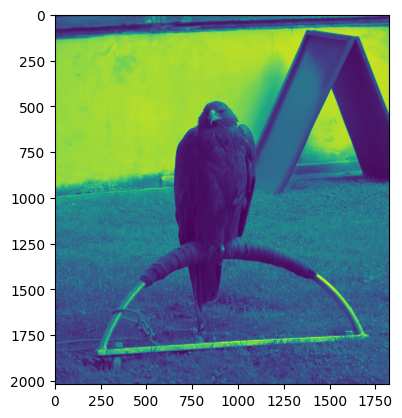

[[ 18  17  17 ... 126 126 123]
 [ 21  21  22 ... 128 127 124]
 [ 25  26  27 ... 130 129 125]
 ...
 [ 67  56  51 ...  68  65  63]
 [ 67  61  55 ...  76  73  69]
 [ 69  65  64 ...  75  80  78]]
(2019, 1826)


In [25]:
#eagle = data.eagle().astype(np.float32)
plt.imshow(eagle)
plt.show()
#array de numpy con los pixeles
print(eagle)
#shape (i.e., dimensiones) del array de numpy
print(eagle.shape)

In [32]:
@cuda.jit
# El filtro de media funciona convolucionando cada píxel de la imagen con un kernel (una pequeña matriz) y luego reemplaza el valor de ese píxel 
# por el promedio (o suma) de los valores de los píxeles en el vecindario definido por el kernel.
def rgb(eagle,output,size):
  r, c = cuda.grid(2)
  if (r + 2) < size[0] and (c + 2) < size[1] and (r > 2) and (c > 2 ):
    divisor = 75
    # Esta implementación también tiene en cuenta los bordes de la imagen, asegurando que la operación de convolución no se aplica a los píxeles 
    # en los bordes, ya que no tendrían suficientes vecinos para formar el kernel completo.
    sum = eagle[r-2][c-1]/divisor + eagle[r-2][c]/divisor + eagle[r-2][c+1]/divisor + eagle[r-1][c-1]/divisor + \
    eagle[r-1][c]/divisor + eagle[r-1][c+1]/divisor + eagle[r][c-1]/divisor + eagle[r][c]/divisor + eagle[r][c+1]/divisor + \
    eagle[r+1][c-1]/divisor + eagle[r+1][c]/divisor + eagle[r+1][c+1]/divisor + eagle[r+2][c-1]/divisor + eagle[r+2][c]/divisor + \
    eagle[r+2][c+1]/divisor
  output[r][c] = round(sum/15)

In [37]:
# Primero, se crea una copia de la imagen original (la variable 'eagle') en la memoria de la CPU
host_pixels = eagle

# Luego, se crea una copia de la imagen en la memoria de la GPU
device_pixels = cuda.to_device(host_pixels)

# A continuación, se reserva el espacio para la imagen de salida en la memoria de la GPU
device_output = cuda.device_array(host_pixels.shape)

# Aquí se define el tamaño del bloque de threads para la GPU. En este caso, cada bloque contendrá 16x16=256 threads
threads_per_block = (16,16)

# Calculamos el número de bloques en la cuadrícula de la GPU a lo largo de las dimensiones x e y.
# Tomamos el techo de la división para asegurarnos de que todos los píxeles de la imagen serán cubiertos,
# incluso si el número de píxeles no es divisible exactamente por el tamaño del bloque
blocks_per_grid_x = int(math.ceil(eagle.shape[0]/threads_per_block[0]))
blocks_per_grid_y = int(math.ceil(eagle.shape[1]/threads_per_block[1]))
grid = (blocks_per_grid_x,blocks_per_grid_y)

# Lanzamos el kernel de suavizado en la GPU. Le pasamos la cuadrícula y el tamaño del bloque como argumentos,
# así como la imagen de entrada y de salida, y el tamaño de la imagen.
rgb[grid,threads_per_block](device_pixels,device_output,host_pixels.shape)

# Después de que el kernel ha terminado de ejecutarse, copiamos la imagen suavizada de vuelta a la memoria de la CPU
# utilizando 'copy_to_host', y la asignamos de nuevo a la variable 'host_pixels'
host_pixels = device_output.copy_to_host()

# Finalmente, imprimimos la imagen suavizada
print(host_pixels)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


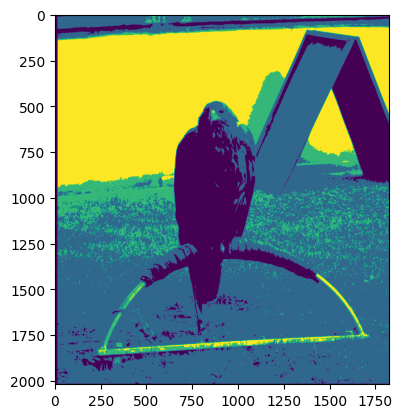

In [38]:
plt.imshow(host_pixels)